# Project 1 Neuronal networks

## 1.- MNIST and FMINST datasets

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
#!pip install wandb
import wandb # Weight & Biases library to monitor training and compare models
wandb.login() # API key: 569de9861dbe18fe8888f13ca66e39d2b12934ff

/home/vm/anaconda3/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alejogonzalez9 (zurdito). Use `wandb login --relogin` to force relogin


True

To obtain the MNIST dataset:

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
train_MNIST = torch.utils.data.DataLoader(trainsetMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetMNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_MNIST = torch.utils.data.DataLoader(testsetMNIST, batch_size=64, shuffle=True)

To obtain the FMINST dataset:

In [4]:

# Download and load the training data
trainsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_FMNIST = torch.utils.data.DataLoader(trainsetFMNIST, batch_size=64, shuffle=True)

# Download and load the test data
testsetFMNIST = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_FMNIST = torch.utils.data.DataLoader(testsetFMNIST, batch_size=64, shuffle=True)

In [5]:
dataiter = iter(train_MNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


In [6]:
dataiter = iter(train_FMNIST)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


We can see that our images are of size 28 x 28 = 784, so the input layer is of size 784. It is important to see that the range of the values are -1,1 so for the output layer we will use the tanh.

We also need to split the training data into training and validation sets.

In [7]:
import copy


valid_MNIST = copy.deepcopy(train_MNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_MNIST.dataset.data = train_MNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_MNIST.dataset.data = valid_MNIST.dataset.data[45000:,:,:]


In [8]:
import copy

valid_FMNIST = copy.deepcopy(train_FMNIST)  # Creates a copy of the object

#We take the first 45k images for training
train_FMNIST.dataset.data = train_FMNIST.dataset.data[:45000,:,:]

#And the rest for validation
valid_FMNIST.dataset.data = valid_FMNIST.dataset.data[45000:,:,:]

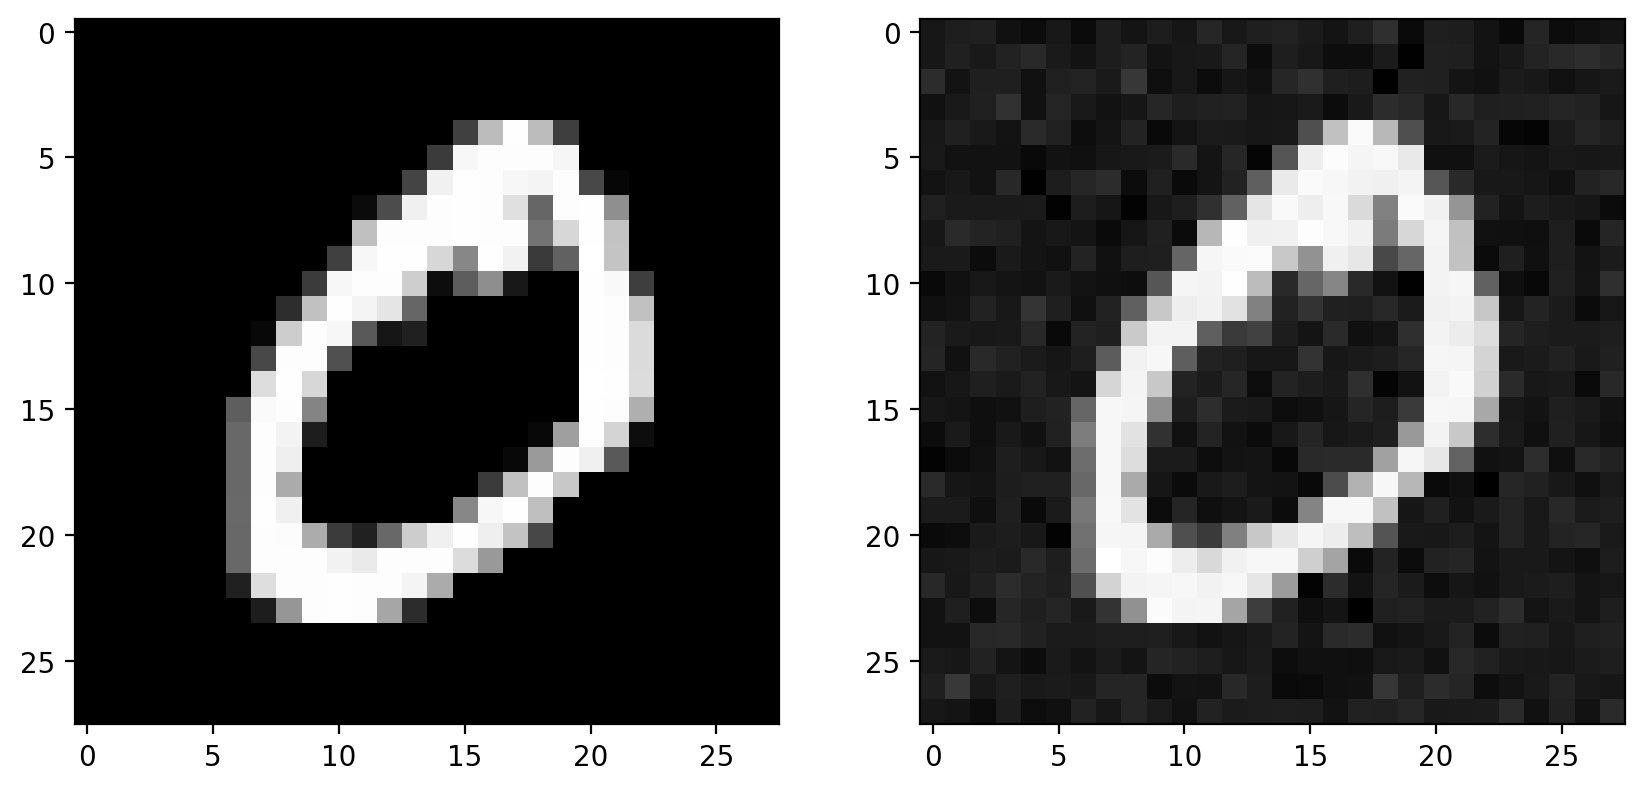

In [9]:
def add_noise(img, variance):
    noise = np.random.normal(loc=0, scale=np.sqrt(variance), size=img.shape)
    noisy_img = img + noise
    return noisy_img


img = train_MNIST.dataset.data[1,:,:]
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(add_noise(img,100).numpy().reshape([28,28]), cmap='Greys_r')



Select Data Set To Be Trained:

In [10]:
INDEX = 0 # INDEX = 0 for MNIST and 1 for FMNIST!
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into

train_set = [train_MNIST, train_FMNIST]
valid_set = [valid_MNIST, valid_FMNIST]
test_set =  [test_MNIST, test_FMNIST]

## 3 layers at both encoder/decoder:


In [11]:

class autoencoder3(nn.Module):
    def __init__(self, projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.INDEX = INDEX


        if self.INDEX == 0:  # MNIST
            self.name_train = f"3_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img_noised = add_noise(img,4)
                img = img.reshape(-1, self.input_image_size)
                img_noised = img_noised.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img_noised.float())

                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    img_noised = add_noise(images,4)
                    img_noised = img_noised.reshape(-1, self.input_image_size)
                    images = images.reshape(-1, self.input_image_size)
                    encod,reconstruct = self.forward(img_noised.float())

                    loss_valid = self.criterion(reconstruct,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              _,reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

Definition of parameters of the model and Peak signal-to-noise ratio (PSNR)

Training the model

In [14]:
    for run in range(len(projected_dimensions)):
        print(run)

0
1
2
3


In [12]:
def train_models(projected_dimensions, autoencoder, epochs, train_set, valid_set, INDEX):
    models_autoencoder = []
    for run in range(len(projected_dimensions)):
        model = autoencoder(projected_dimensions[run], INDEX)  # To initialize the model with the projected dimension
        model.do_training(epochs, train_set[INDEX], valid_set[INDEX])
        models_autoencoder.append(model)
    return models_autoencoder

In [15]:
epochs = 30
models_autoencoder3 = train_models(projected_dimensions, autoencoder3, epochs, train_set, valid_set, INDEX)

Epoch:  1 Loss train:  0.1988509541208094 , Loss valid:  0.1620244231629879
Epoch:  2 Loss train:  0.15230834712697702 , Loss valid:  0.14948324865483223
Epoch:  3 Loss train:  0.14440139444460245 , Loss valid:  0.14301766829287751
Epoch:  4 Loss train:  0.14027345325501467 , Loss valid:  0.13933203347185824
Epoch:  5 Loss train:  0.13707380292048169 , Loss valid:  0.13699357192567055
Epoch:  6 Loss train:  0.13480332978493112 , Loss valid:  0.13518014131708347
Epoch:  7 Loss train:  0.13312680724034595 , Loss valid:  0.13498640627937114
Epoch:  8 Loss train:  0.13176461547316815 , Loss valid:  0.1318012667463181
Epoch:  9 Loss train:  0.13070793720808896 , Loss valid:  0.13079870546117742
Epoch:  10 Loss train:  0.12937168985478242 , Loss valid:  0.13013465518647052
Epoch:  11 Loss train:  0.12762629383624616 , Loss valid:  0.12870116065791312
Epoch:  12 Loss train:  0.1264982909408652 , Loss valid:  0.12727488628093234


KeyboardInterrupt: 

In [ ]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
epochs = 30
models_autoencoder3 = []
for run in range(len(projected_dimensions)):
    model = autoencoder3(projected_dimensions[run])  # To initialize the model with the projected dimension
    model.do_training(epochs,train_set[INDEX],valid_set[INDEX])
    models_autoencoder3.append(model)

In [ ]:
epochs = 30
models_autoencoder5 = []
for run in range(len(projected_dimensions)):
    model = autoencoder5(projected_dimensions[run], INDEX)  # To initialize the model with the projected dimension
    model.do_training(epochs,train_MNIST,valid_MNIST)
    models_autoencoder5.append(model)

Visualization of reconstructed images

In [ ]:
img = train_set[INDEX].dataset.data[1,:,:]
noised_img = add_noise(img, 100)
plt.imshow(img.numpy().reshape([28,28]), cmap='Greys_r')

In [ ]:
plt.imshow(noised_img.numpy().reshape([28,28]), cmap='Greys_r')

In [ ]:
noised_img = noised_img.reshape(-1, 784)
reconstructed = models_autoencoder3[-1].forward(noised_img.float())
plt.imshow(reconstructed.detach().numpy().reshape([28,28]))

# 5 layers at both encoder/decoder:

In [ ]:
class autoencoder5(nn.Module):
    def __init__(self,projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.INDEX = INDEX
        
        if self.INDEX == 0:  # MNIST
            self.name_train = f"5_layer_with_PSNR_train_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_with_PSNR_train_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_with_PSNR_test_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")


        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension),
            nn.ReLU()
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )

        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()


        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                reconstructed = self.forward(img)
                loss_train = self.criterion(reconstructed, img)

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    out = self.forward(images)

                    loss_valid = self.criterion(out,images)

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance

In [ ]:
epochs = 30
models_autoencoder5 = train_models(projected_dimensions, autoencoder5, epochs, train_set, valid_set, INDEX)

# Save the models

In [ ]:
def save_models(projected_dimensions, models_autoencoder3, models_autoencoder5, INDEX):
    if INDEX == 0:  # MNIST
        for i in range(len(models_autoencoder3)):
            torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_MNIST_{projected_dimensions[i]}.pth')
            torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_MNIST_{projected_dimensions[i]}.pth')
    elif INDEX == 1:  # FMNIST
        for i in range(len(models_autoencoder3)):
            torch.save(models_autoencoder3[i].state_dict(), f'model_autoencoder3_FMNIST_{projected_dimensions[i]}.pth')
            torch.save(models_autoencoder5[i].state_dict(), f'model_autoencoder5_FMNIST_{projected_dimensions[i]}.pth')
    else:
        raise ValueError("While saving the models, INDEX should be either 0 or 1.")


In [ ]:
save_models(projected_dimensions, models_autoencoder3, models_autoencoder5, INDEX)

Load the models

In [ ]:
def load_models(projected_dimensions, autoencoder3, autoencoder5, models_autoencoder3, models_autoencoder5, INDEX):
    if INDEX == 0:  # MNIST
        dataset0 = "MNIST"
    else:
        dataset0 = "FMNIST"

    for i in range(len(projected_dimensions)):
        state_dict_3 = torch.load(f'model_autoencoder3_{dataset0}_{projected_dimensions[i]}.pth')
        model_3 = autoencoder3(projected_dimensions[i], INDEX)  # Assuming autoencoder3 is defined elsewhere
        model_3.load_state_dict(state_dict_3)
        models_autoencoder3.append(model_3)

        state_dict_5 = torch.load(f'model_autoencoder5_{dataset0}_{projected_dimensions[i]}.pth')
        model_5 = autoencoder5(projected_dimensions[i], INDEX)  # Assuming autoencoder5 is defined elsewhere
        model_5.load_state_dict(state_dict_5)
        models_autoencoder5.append(model_5)

In [ ]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
models_autoencoder3 = []
models_autoencoder5 = []
load_models(projected_dimensions, autoencoder3, autoencoder5, models_autoencoder3, models_autoencoder5, INDEX)

In [ ]:
# print(models_autoencoder3.__len__())
print(type(models_autoencoder3[0]))

<class '__main__.autoencoder3'>


Evaluation of the performance of the models without regularization

In [ ]:
def evaluate_models(models, train, valid, test):
    for n_layers in range(len(models)):
        for i, model in enumerate(models[n_layers]):
            n_lay = 3 if n_layers == 0 else 5
            print(f"Autoenc{n_lay}, train-{projected_dimensions[i]}. Projections:", model.eval_performance(train))
            print(f"Autoenc{n_lay}, val-{projected_dimensions[i]}. Projections:", model.eval_performance(valid))
            print(f"Autoenc{n_lay}, test-{projected_dimensions[i]}. Projections:", model.eval_performance(test), "\n")

In [ ]:
# models_autoencoder5[0].eval_performance(train_MNIST)

tensor(6.3856)

In [ ]:
# models_autoencoder3[0].eval_performance(train_MNIST)

tensor(6.9861)

In [ ]:
models = [models_autoencoder3, models_autoencoder5]
evaluate_models(models, train_set[INDEX], valid_set[INDEX], test_set[INDEX]) # TO DO change test to F and MNIST

Autoenc3, train-15. Projections: tensor(7.5716)
Autoenc3, val-15. Projections: tensor(7.1226)
Autoenc3, test-15. Projections: tensor(6.0108) 

Autoenc3, train-30. Projections: tensor(5.5049)
Autoenc3, val-30. Projections: tensor(6.7900)
Autoenc3, test-30. Projections: tensor(5.7279) 

Autoenc3, train-50. Projections: tensor(7.9805)
Autoenc3, val-50. Projections: tensor(7.9646)
Autoenc3, test-50. Projections: tensor(7.6248) 

Autoenc3, train-100. Projections: tensor(9.2960)
Autoenc3, val-100. Projections: tensor(9.7875)
Autoenc3, test-100. Projections: tensor(8.2361) 

Autoenc5, train-15. Projections: tensor(7.0383)
Autoenc5, val-15. Projections: tensor(6.2816)
Autoenc5, test-15. Projections: tensor(5.9804) 

Autoenc5, train-30. Projections: tensor(8.1124)
Autoenc5, val-30. Projections: tensor(7.5295)
Autoenc5, test-30. Projections: tensor(6.9988) 

Autoenc5, train-50. Projections: tensor(6.3666)
Autoenc5, val-50. Projections: tensor(7.0647)
Autoenc5, test-50. Projections: tensor(6.8788

After analysing the losses of the train and validation sets we can see that we can apply early stopping in 15 epochs because the validation loss is getting small slowly after that point.

## Training the models with early stopping, dropout and Lasso regularization

In [ ]:

class autoencoder3_regularized(nn.Module):
    def __init__(self, projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5
        self.INDEX = INDEX

        if self.INDEX == 0:  # MNIST
            self.name_train = f"3_layer_train_dropout_MNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_test_dropout_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"3_layer_train_dropout_FMNIST_{self.projected_dimension}"
            self.name_test = f"3_layer_test_dropout_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder3, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(self.input_image_size, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2), # Dropout with a probability of 0.2
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, self.projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(self.projected_dimension, 150),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(150, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, self.input_image_size),
            nn.Tanh(),
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img)
                l1_reg = torch.abs(enco).sum()
                loss_train = self.criterion(reconstructed, img) + self.lambd*l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    enco,out = self.forward(images)
                    l1_reg = torch.abs(enco).sum()
                    loss_valid = self.criterion(out,images) + self.lambd*l1_reg

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance


In [ ]:
epochs = 15
models_autoencoder3_regularized = train_models(projected_dimensions, autoencoder3_regularized, epochs, train_set, valid_set, INDEX)

In [ ]:
class autoencoder5_regularized(nn.Module):
    def __init__(self, projected_dimension, INDEX):
        super().__init__()
        self.projected_dimension = projected_dimension
        self.criterion = nn.MSELoss()
        self.learning_rate = 0.001
        self.lambd = 1e-5
        self.INDEX = INDEX

        if self.INDEX == 0:  # MNIST
            self.name_train = f"5_layer_train_dropout_MNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_test_dropout_MNIST_{self.projected_dimension}"
            self.dataset = "MNIST"

        elif self.INDEX == 1:  # FMNIST
            self.name_train = f"5_layer_train_dropout_FMNIST_{self.projected_dimension}"
            self.name_test = f"5_layer_test_dropout_FMNIST_{self.projected_dimension}"
            self.dataset = "FMNIST"

        else:
            raise ValueError("Inside autoencoder5, INDEX should be either 0 or 1.")

        self.project = "project_1"
        self.architecture = "linear_autoencoder"
        self.input_image_size = 784
        self.outputs = []
        self.loss_during_training = []
        self.valid_loss_during_training = []



        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 -> projected dimension
        self.encoder = nn.Sequential(
            nn.Linear(784, 550),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(550, 400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300,200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200,projected_dimension),
            nn.ReLU(),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # projected dimension -> 784
        self.decoder = nn.Sequential(
            nn.Linear(projected_dimension, 200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(300, 400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(400,550),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(550,784),
            nn.Tanh()
        )
        self.optimizer = optim.Adam(self.parameters(), self.learning_rate)

    def forward(self, image):
        encoded = self.encoder(image)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def psnr(self, img1, img2):  #  Peak signal-to-noise ratio (PSNR)
        mse_criterio = nn.MSELoss()
        mse = mse_criterio(img1, img2)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr

    def do_training(self, epochs, train_data, valid_data):
        self.train()




        wandb.init(  # Esto es para que se guarde en la plataforma de wandb y nos evitamos tener que hacerlo manualmente
            # Set the project where this run will be logged
            project=self.project,
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name=self.name_train,
            # Track hyperparameters and run metadata
            config={
                "learning_rate": self.learning_rate,
                "architecture": self.architecture,
                "dataset": self.dataset,
                "epochs": epochs,
            },
        )

        # Aqui es donde empieza realmente el entrenamiento
        for epoch in range(epochs):
            running_loss = 0.
            for img, _ in train_data:
                self.optimizer.zero_grad()
                img = img.reshape(-1, self.input_image_size)
                enco,reconstructed = self.forward(img)
                l1_reg = torch.abs(enco).sum()
                loss_train = self.criterion(reconstructed, img) + self.lambd*l1_reg

                running_loss += loss_train.item()
                loss_train.backward()
                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_data))

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                for images,_ in valid_data:

                    images = images.reshape(-1, self.input_image_size)

                    enco,out = self.forward(images)
                    l1_reg = torch.abs(enco).sum()
                    loss_valid = self.criterion(out,images) + self.lambd*l1_reg

                    running_loss += loss_valid.item()
                self.valid_loss_during_training.append(running_loss/len(valid_data))

            # set model back to train mode
            self.train()

            print("Epoch: ", epoch + 1, "Loss train: ", self.loss_during_training[-1], ", Loss valid: ", self.valid_loss_during_training[-1])
            wandb.log({"projected dimension": projected_dimensions[run], "Loss train": self.loss_during_training[-1], "Loss valid": self.valid_loss_during_training[-1]})
            self.outputs.append((projected_dimensions[run], epoch, img, reconstructed))

        wandb.finish()

    def eval_performance(self,data_test):

      performance = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          # set model to evaluation mode
          self.eval()

          for images,_ in data_test:

              img = images.view(-1, self.input_image_size)
              reconstructed = self.forward(img)
              performance = self.psnr(reconstructed, img)


          return performance


In [ ]:
epochs = 15
models_autoencoder5_regularized = train_models(projected_dimensions, autoencoder5_regularized, epochs, train_set, valid_set, INDEX)

Save the models

In [ ]:
save_models(projected_dimensions, models_autoencoder3_regularized, models_autoencoder5_regularized, INDEX)

Load the models

In [ ]:
projected_dimensions = [15, 30, 50, 100] # This are the dimensions we are going to project the data into
models_autoencoder3 = []
models_autoencoder5 = []
load_models(projected_dimensions, autoencoder3_regularized, autoencoder5_regularized, models_autoencoder3, models_autoencoder5, INDEX)

Evaluation of performance after regularization

In [ ]:
models = [models_autoencoder3_regularized, models_autoencoder5_regularized]
evaluate_models(models, train_MNIST, valid_MNIST, test_MNIST)

After looking at the performance we have chosen the model with

# Denoising autoencoder

Now for the best model we have found we will train a new one with noisy images and compare the output with the original ones. We will tune the variance of the noise we are introducing

Visualization of the denoising autoencoder